In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import re
import string
from IPython.display import display

import tensorflow as tf
from tensorflow.keras.utils import text_dataset_from_directory
from tensorflow.keras.layers import TextVectorization, Input, Embedding, Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential

# Basic Text Classification (repeat)

Класификация на отзиви за филми - положителен или отрицателен отзив.

## Constants

In [4]:
SEED = 123
BATCH_SIZE = 32
MAX_TOKENS = 10_000  # the number of unique words (and ngrams) in the dictionary (vocabulary) will be max 10K
OUTPUT_SEQUENCE_LENGTH = 250  # each int encoding of a text will contain exactly 250 numbers
AUTOTUNE = tf.data.AUTOTUNE

## Open directory

### Folder

In [5]:
movies_path = os.path.join(
    os.environ['HOME'],
    'Desktop/datasets/aclImdb',
)

os.listdir(movies_path)

['imdb.vocab', 'imdbEr.txt', 'README', 'test', 'train']

## Explore data

### Integrated vocabulary.

In [6]:
with open(os.path.join(movies_path, 'imdb.vocab'), encoding='ISO-8859-1') as f:
    vocab = [v.strip() for v in f.readlines()[:10]]
    print(', '.join(vocab))

the, and, a, of, to, is, it, in, i, this


### Sample review. Случаен отзив.

In [7]:
path_train_positive = os.path.join(movies_path, 'train', 'pos')
a_file = os.listdir(path_train_positive)[123]
with open(os.path.join(path_train_positive, a_file)) as f:
    print(f.read())

Any story comprises a premise, characters and conflict. Characters plotting their own play promises triumph, and a militant character readily lends oneself to this. Ardh Satya's premise is summarized by the poem of the same name scripted by Dilip Chitre. The line goes - "ek palde mein napunsaktha, doosre palde mein paurush, aur teek tarazu ke kaante par, ardh satya ?". A rough translation - "The delicate balance of right & wrong ( commonly seen on the busts of blind justice in the courts ) has powerlessness on one plate and prowess on another. Is the needle on the center a half-truth ? "<br /><br />The poem is recited midway in the film by Smita Patil to Om Puri at a resturant. It makes a deep impact on the protagonist & lays the foundation for much of the later events that follow. At the end of the film, Om Puri ends up in exactly the same situation described so aptly in the poem.<br /><br />The film tries mighty hard to do a one-up on the poem. However, Chitre's words are too powerfu

## Create datasets

### Directories, train and test.

In [8]:
path_train = os.path.join(movies_path, 'train')
path_test = os.path.join(movies_path, 'test')

### Datasets, training and val.

In [16]:
raw_training_ds, raw_val_ds = text_dataset_from_directory(
    directory=path_train,
    labels='inferred',
    label_mode='int',
    batch_size=BATCH_SIZE,
    max_length=None,
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset='both',
)

raw_training_ds, raw_val_ds

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Using 5000 files for validation.


(<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

### Test: number of records.

In [17]:
n_training = raw_training_ds.cardinality().numpy() * BATCH_SIZE
n_validation = raw_val_ds.cardinality().numpy() * BATCH_SIZE

n_training, n_validation

(20000, 5024)

### Test: sample review.

Случаен отзив и неговия клас.

In [18]:
for texts_batch, labels_batch in raw_training_ds.take(1):
    sample_review = texts_batch[0].numpy()
    sample_label = labels_batch[0].numpy()
    print(sample_review, sample_label, sep='\n')

b'After, I watched the films... I thought, "Why the heck was this film such a high success in the Korean Box Office?" Even thought the movie had a clever/unusal scenario, the acting wasn\'t that good and the characters weren\'t very interesting. For a Korean movie... I liked the fighting scenes. If you want to watch a film without thinking, this is the film for you. But I got to admit... the film was kind of childish... 6/10'
1


### Dataset, test.

In [19]:
display(os.path.exists(path_test))

raw_test_ds = text_dataset_from_directory(
    directory=path_test,
    labels='inferred',
    label_mode='int',
    class_names=None,
    batch_size=BATCH_SIZE,
    max_length=None,
    shuffle=True,
    seed=SEED,
)

True

Found 25000 files belonging to 2 classes.


In [20]:
raw_test_ds.class_names

['neg', 'pos']

## Prepare the dataset for training

### Preprocessing
Implement a function to clean each review.

3 стъпки:
1. всички букви -> малки
1. махаме хтмл тагове
1. махаме пунктуационни знаци

In [21]:
def clean_review(review):
    cleaned = tf.strings.lower(review)
    cleaned = tf.strings.regex_replace(cleaned, '<[^>]+>', '')
    cleaned = tf.strings.regex_replace(cleaned, f'[{re.escape(string.punctuation)}]', '')
    
    return cleaned

print(sample_review, clean_review(sample_review), sep='\n\n')

b'After, I watched the films... I thought, "Why the heck was this film such a high success in the Korean Box Office?" Even thought the movie had a clever/unusal scenario, the acting wasn\'t that good and the characters weren\'t very interesting. For a Korean movie... I liked the fighting scenes. If you want to watch a film without thinking, this is the film for you. But I got to admit... the film was kind of childish... 6/10'

tf.Tensor(b'after i watched the films i thought why the heck was this film such a high success in the korean box office even thought the movie had a cleverunusal scenario the acting wasnt that good and the characters werent very interesting for a korean movie i liked the fighting scenes if you want to watch a film without thinking this is the film for you but i got to admit the film was kind of childish 610', shape=(), dtype=string)


### `TextVectorization` layer

In [22]:
vectorize_layer = TextVectorization(
    max_tokens=MAX_TOKENS,
    standardize=clean_review,
    split='whitespace',
    ngrams=None,
    output_mode='int',
    output_sequence_length=OUTPUT_SEQUENCE_LENGTH,
    encoding='utf-8',
)

### Datasets, only input

In [23]:
raw_training_ds

<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [24]:
train_data = raw_training_ds.map(lambda review, label: review)


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


### Vocabulary

Compute vocab.
Vocab is ordered (most frequent words first).

In [25]:
vectorize_layer.adapt(train_data)
vectorize_layer.get_vocabulary()[:10]

['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it']

### Test: sample review

The **words are integer encoded** - a unique number is assigned to each word. The whole text on the other hand becomes a sequence of those numbrers - the **text is multi-hot** encoded.

In [26]:
# The review printed below is before preprocessing 
# that is before lowercasing, removing punctuation and html.
sample_review = list(train_data.as_numpy_iterator())[0][0]
display(sample_review)
display(vectorize_layer(sample_review))

b"This Documentary (Now available free on Video.Google.Com) is a fantastic demonstration of the power of ordinary people to overcome injustice. Everyone must see this.<br /><br />Chavez was elected in a landslide vote in 1998. His platform was to divert the fantastic oil wealth from the 20% middle class to the 80% poor. He banned foreign drift net fishing in Venezuelan waters. He sent 10,000 Cuban doctors to the slums to treat the sick for free. He wiped out illiteracy and set up new free Universities. <br /><br />But it was his 30% tax on oil company profits that got him in trouble with the Bush administration. In 2002, while Irish film makers Kim Bartley and Donnacha O'Briain were interviewing Chavez inside the Presidential Palace about his social programs, a CIA backed coup was launched. With the cameras rolling, Chavez was captured and flown out of the country. It was announced on national TV that he had 'resigned'.<br /><br />But the poor of Venezuela didn't believe the media. The

<tf.Tensor: shape=(250,), dtype=int64, numpy=
array([  10,  676,  158, 1412,  962,   20,    1,    7,    4,  768,    1,
          5,    2,  664,    5, 1809,   77,    6, 3042, 8554,  302,  217,
         65,    1,   13, 8402,    8,    4,    1, 2187,    8, 6825,   24,
       7397,   13,    6,    1,    2,  768, 3340, 3671,   36,    2,  955,
        759,  797,    6,    2, 3461,  339,   27, 3921, 2060, 8011, 5767,
       5627,    8,    1, 3956,   27, 1345,    1, 6336, 3835,    6,    2,
          1,    6, 1656,    2, 1187,   16,  962,   27, 6585,   44,    1,
          3,  272,   54,  153,  962,    1,   18,    9,   13,   24, 1183,
       6840,   20, 3340, 1145, 9978,   12,  183,   88,    8, 1137,   15,
          2, 3458, 9612,    8, 3847,  136, 2524,   19, 1346, 2560,    1,
          3,    1,    1,   66,    1, 6344,  979,    2, 8951, 5388,   42,
         24, 1007, 5528,    4, 3600, 7342, 5801,   13,    1,   15,    2,
       3948, 2698, 6344,   13, 1798,    3,    1,   44,    5,    2,  694,
     

### Final datasets

Contain both input (vectorized amazon review) and the label.

In [27]:
def vectorize_ds(review, label):
    review = vectorize_layer(review)
    return review, label

train_ds = raw_training_ds.map(vectorize_ds)
val_ds = raw_val_ds.map(vectorize_ds)
test_ds = raw_test_ds.map(vectorize_ds)

display(train_ds)
display(val_ds)
display(test_ds)

<MapDataset element_spec=(TensorSpec(shape=(None, 250), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

<MapDataset element_spec=(TensorSpec(shape=(None, 250), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

<MapDataset element_spec=(TensorSpec(shape=(None, 250), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

### Test: single batch

32 texts (review), 250 integers each. Each integer represents a unique word. The words are integer encoded, the sentences are multi-hot encoded.

In [28]:
first_train_batch = next(iter(train_ds))
first_train_batch

(<tf.Tensor: shape=(32, 250), dtype=int64, numpy=
 array([[  11,  253,   10, ...,    0,    0,    0],
        [1020, 2288, 3077, ...,    0,    0,    0],
        [ 651, 1981,    1, ...,    7, 3940,   46],
        ...,
        [ 121,  233,   11, ..., 5329,   74,   26],
        [  10,  348,   19, ...,    0,    0,    0],
        [   2, 3170,    5, ...,    0,    0,    0]], dtype=int64)>,
 <tf.Tensor: shape=(32,), dtype=int32, numpy=
 array([1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 1, 1])>)

## Configure for performance

In [29]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Create model

In [32]:
model = Sequential([
    Embedding(input_dim=MAX_TOKENS+1, output_dim=16),
    GlobalAveragePooling1D(),
    Dense(1)])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          160016    
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


## Add loss func and optimizer

The three types of cross-entropy loss functions in TensorFlow are binary_crossentropy, categorical_crossentropy, and sparse_categorical_crossentropy. While all three loss functions measure the dissimilarity between the predicted probabilities and the true labels, there are some differences in their input requirements and use cases.

binary_crossentropy: This loss function is used for binary classification problems where there are only two classes. It expects the model output to be a scalar value between 0 and 1, representing the predicted probability of the positive class. The true label should be either 0 or 1. The formula for binary cross-entropy is:

$L(y, \hat{y}) = -(y\log(\hat{y}) + (1-y)\log(1-\hat{y}))$

where $y$ is the true label, $\hat{y}$ is the predicted probability, and $\log$ is the natural logarithm.

categorical_crossentropy: This loss function is used for multi-class classification problems where there are more than two classes. It expects the model output to be a vector of probabilities for each class, with the sum of probabilities equal to 1. The true label should be a one-hot encoded vector. The formula for categorical cross-entropy is:

$L(y, \hat{y}) = -\sum_{i} y_i \log(\hat{y_i})$

where $y$ is the true label (one-hot encoded), $\hat{y}$ is the predicted vector of probabilities, $y_i$ is the $i$-th element of $y$, and $\hat{y_i}$ is the $i$-th element of $\hat{y}$.

sparse_categorical_crossentropy: This loss function is used for multi-class classification problems where there are more than two classes and the true label is not one-hot encoded but represented as integers. It expects the model output to be a vector of probabilities for each class, with the sum of probabilities equal to 1. The true label should be an integer vector. The formula for sparse categorical cross-entropy is the same as categorical cross-entropy, but the true label vector $y$ is not one-hot encoded.

In summary, binary_crossentropy is used for binary classification problems, categorical_crossentropy is used for multi-class classification problems with one-hot encoded labels, and sparse_categorical_crossentropy is used for multi-class classification problems with integer labels.

In [78]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## Train the model

Обучаваме модела.

In [79]:
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
625/625 [==============================] - 6s 7ms/step - loss: 0.8173 - accuracy: 0.5598 - val_loss: 0.6504 - val_accuracy: 0.7336
Epoch 2/10
625/625 [==============================] - 4s 6ms/step - loss: 0.6017 - accuracy: 0.8062 - val_loss: 0.5521 - val_accuracy: 0.8322
Epoch 3/10
625/625 [==============================] - 4s 6ms/step - loss: 0.4758 - accuracy: 0.8443 - val_loss: 0.4350 - val_accuracy: 0.8458
Epoch 4/10
625/625 [==============================] - 4s 7ms/step - loss: 0.3672 - accuracy: 0.8721 - val_loss: 0.3851 - val_accuracy: 0.8708
Epoch 5/10
625/625 [==============================] - 5s 8ms/step - loss: 0.3114 - accuracy: 0.8885 - val_loss: 0.3676 - val_accuracy: 0.8742
Epoch 6/10
625/625 [==============================] - 5s 8ms/step - loss: 0.2756 - accuracy: 0.9017 - val_loss: 0.3747 - val_accuracy: 0.8738
Epoch 7/10
625/625 [==============================] - 4s 7ms/step - loss: 0.2469 - accuracy: 0.9093 - val_loss: 0.4071 - val_accuracy: 0.8754
Epoch 

## Evaluate the model

In [81]:
loss, metrics = model.evaluate(test_ds)

782/782 [==============================] - 3s 4ms/step - loss: 0.5203 - accuracy: 0.8662


In [82]:
loss, metrics

(0.5202870965003967, 0.8661999702453613)

## Inspect training process

In [83]:
history.epoch

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [84]:
history.model

In [102]:
epochs = history.epoch
train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

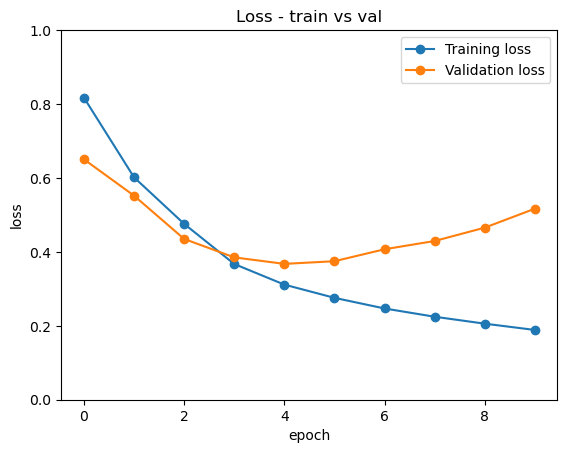

In [106]:
plt.plot(epochs, train_loss, 'o-', label='Training loss')
plt.plot(epochs, val_loss, 'o-', label='Validation loss')

plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim((0, 1))
plt.legend()
plt.title('Loss - train vs val')
plt.show()

## DEMO `cos` between vectors

In [63]:
# Helper function to get the cosine between two vectors
def get_cos(a, b):
    dot_product = tf.tensordot(a, b, axes=1)
    len_a = tf.norm(a)
    len_b = tf.norm(b)
    cosine = dot_product / (len_a * len_b)
    return cosine

a = tf.constant([0.0, 1.0])
b = tf.constant([2.0, 0.0])
c = tf.constant([4.0, 0.0])
d = tf.constant([1.0, 1.0])

get_cos(a, b).numpy(), get_cos(b, c).numpy(), get_cos(c, d).numpy()

(0.0, 1.0, 0.70710677)

In [30]:
embedding = model.layers[0]

# Two similar words
word_067 = vectorize_layer.get_vocabulary()[67]
word_105 = vectorize_layer.get_vocabulary()[105]
print(word_067, word_105)

# Expecting the words to be similar therefore
# the cos to be close to 1
a = embedding(tf.constant(67))
b = embedding(tf.constant(105))
print(f'Cos({word_067}, {word_105}) = {get_cos(a, b)}')    

# Expecting cos close to 0 for dissimilar words
# take word 5000 at random
word_5000 = vectorize_layer.get_vocabulary()[5000]
c = embedding(tf.constant(5000))
print(f'Cos({word_067}, {word_5000}) = {get_cos(a, c)}')    

see seen
Cos(see, seen) = 0.986045241355896
Cos(see, depicting) = -0.9597927927970886


## DEMO Encoding (1)

### Define a Vectorizer layer.

In [22]:
vectorizer = TextVectorization(name='dummy_vectorizer')
texts = [
	"She she doesn’t study German on Monday.",
	"Does she live in Paris?",
	"He doesn’t teach math.",
	"Cats hate water.",
	# "Every child likes an ice cream.",
	# "My brother takes out the trash.",
	# "The course starts next Sunday.",
	# "She swims every morning.",
	# "I don’t wash the dishes.",
	# "We see them every week.",
	# "I don’t like tea.",
	# "When does the train usually leave?",
	# "She always forgets her purse.",
	# "You don’t have children.",
	# "I and my sister don’t see each other anymore.",
	# "They don’t go to school tomorrow.",
]

### Teach vocab.

In [23]:
vectorizer.adapt(texts)

### Display some attributes.

In [24]:
# `[UNK]` =  unknown word
display(vectorizer.vocabulary_size())
display(vectorizer.dtype)
display(vectorizer.name)
display(vectorizer.get_vocabulary()[:8])

18

'string'

'dummy_vectorizer'

['', '[UNK]', 'she', 'doesn’t', 'water', 'teach', 'study', 'paris']

### Default integer encoding

In [25]:
# Default integer encoding: integer indices, one integer index per split string token.
# Each sentence need to be a separate record -> `tf.expand_dims()`.
display(texts)
display(vectorizer(tf.expand_dims(texts, -1)))

['She she doesn’t study German on Monday.',
 'Does she live in Paris?',
 'He doesn’t teach math.',
 'Cats hate water.']

<tf.Tensor: shape=(4, 7), dtype=int64, numpy=
array([[ 2,  2,  3,  6, 15,  8,  9],
       [16,  2, 11, 12,  7,  0,  0],
       [13,  3,  5, 10,  0,  0,  0],
       [17, 14,  4,  0,  0,  0,  0]], dtype=int64)>

### Cap the number of tokens

In [26]:
# Cap the number of tokens -> a lot of `[UNK]` (unknown words).
vectorizer = TextVectorization(max_tokens=8)
vectorizer.adapt(texts)
display(vectorizer.get_vocabulary())

display(texts)
display(vectorizer(tf.expand_dims(texts, -1)))

['', '[UNK]', 'she', 'doesn’t', 'water', 'teach', 'study', 'paris']

['She she doesn’t study German on Monday.',
 'Does she live in Paris?',
 'He doesn’t teach math.',
 'Cats hate water.']

<tf.Tensor: shape=(4, 7), dtype=int64, numpy=
array([[2, 2, 3, 6, 1, 1, 1],
       [1, 2, 1, 1, 7, 0, 0],
       [1, 3, 5, 1, 0, 0, 0],
       [1, 1, 4, 0, 0, 0, 0]], dtype=int64)>

### Increase the len of the output encoding.

In [27]:
# Increase the len of the output encoding -> trailing zeros.
vectorizer = TextVectorization(max_tokens=8, output_sequence_length=20)
vectorizer.adapt(texts)
display(vectorizer.get_vocabulary())

display(texts)
display(vectorizer(tf.expand_dims(texts, -1)))

['', '[UNK]', 'she', 'doesn’t', 'water', 'teach', 'study', 'paris']

['She she doesn’t study German on Monday.',
 'Does she live in Paris?',
 'He doesn’t teach math.',
 'Cats hate water.']

<tf.Tensor: shape=(4, 20), dtype=int64, numpy=
array([[2, 2, 3, 6, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 2, 1, 1, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 3, 5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
      dtype=int64)>

### Add ngrams

In [28]:
# Add ngrams -> vocabulary size increases.
vectorizer = TextVectorization(ngrams=2)
vectorizer.adapt(texts)
display(vectorizer.get_vocabulary())

display(texts)
display(vectorizer(tf.expand_dims(texts, -1)))

['',
 '[UNK]',
 'she',
 'doesn’t',
 'water',
 'teach math',
 'teach',
 'study german',
 'study',
 'she she',
 'she live',
 'she doesn’t',
 'paris',
 'on monday',
 'on',
 'monday',
 'math',
 'live in',
 'live',
 'in paris',
 'in',
 'he doesn’t',
 'he',
 'hate water',
 'hate',
 'german on',
 'german',
 'doesn’t teach',
 'doesn’t study',
 'does she',
 'does',
 'cats hate',
 'cats']

['She she doesn’t study German on Monday.',
 'Does she live in Paris?',
 'He doesn’t teach math.',
 'Cats hate water.']

<tf.Tensor: shape=(4, 13), dtype=int64, numpy=
array([[ 2,  2,  3,  8, 26, 14, 15,  9, 11, 28,  7, 25, 13],
       [30,  2, 18, 20, 12, 29, 10, 17, 19,  0,  0,  0,  0],
       [22,  3,  6, 16, 21, 27,  5,  0,  0,  0,  0,  0,  0],
       [32, 24,  4, 31, 23,  0,  0,  0,  0,  0,  0,  0,  0]], dtype=int64)>

### One-hot encode

In [29]:
# One-hot encode each text (sentence).
vectorizer = TextVectorization(output_mode='multi_hot')
vectorizer.adapt(texts)
display(vectorizer.get_vocabulary())

display(texts)
display(vectorizer(tf.expand_dims(texts, -1)))

['[UNK]',
 'she',
 'doesn’t',
 'water',
 'teach',
 'study',
 'paris',
 'on',
 'monday',
 'math',
 'live',
 'in',
 'he',
 'hate',
 'german',
 'does',
 'cats']

['She she doesn’t study German on Monday.',
 'Does she live in Paris?',
 'He doesn’t teach math.',
 'Cats hate water.']

<tf.Tensor: shape=(4, 17), dtype=float32, numpy=
array([[0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
        0.],
       [0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1.,
        0.],
       [0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        1.]], dtype=float32)>

### `output_mode='count'`

In [30]:
vectorizer = TextVectorization(output_mode='count')
vectorizer.adapt(texts)
display(vectorizer.get_vocabulary())

display(texts)
display(vectorizer(tf.expand_dims(texts, -1)))

['[UNK]',
 'she',
 'doesn’t',
 'water',
 'teach',
 'study',
 'paris',
 'on',
 'monday',
 'math',
 'live',
 'in',
 'he',
 'hate',
 'german',
 'does',
 'cats']

['She she doesn’t study German on Monday.',
 'Does she live in Paris?',
 'He doesn’t teach math.',
 'Cats hate water.']

<tf.Tensor: shape=(4, 17), dtype=float32, numpy=
array([[0., 2., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
        0.],
       [0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1.,
        0.],
       [0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
        0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        1.]], dtype=float32)>

### One-hot encoding with TF-IDF instead of ints. 

In [31]:
vectorizer = TextVectorization(output_mode='tf-idf')
vectorizer.adapt(texts)
display(vectorizer.get_vocabulary())

display(texts)
display(vectorizer(tf.expand_dims(texts, -1)))

['[UNK]',
 'she',
 'doesn’t',
 'water',
 'teach',
 'study',
 'paris',
 'on',
 'monday',
 'math',
 'live',
 'in',
 'he',
 'hate',
 'german',
 'does',
 'cats']

['She she doesn’t study German on Monday.',
 'Does she live in Paris?',
 'He doesn’t teach math.',
 'Cats hate water.']

<tf.Tensor: shape=(4, 17), dtype=float32, numpy=
array([[0.        , 1.6945957 , 0.84729785, 0.        , 0.        ,
        1.0986123 , 0.        , 1.0986123 , 1.0986123 , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.0986123 ,
        0.        , 0.        ],
       [0.        , 0.84729785, 0.        , 0.        , 0.        ,
        0.        , 1.0986123 , 0.        , 0.        , 0.        ,
        1.0986123 , 1.0986123 , 0.        , 0.        , 0.        ,
        1.0986123 , 0.        ],
       [0.        , 0.        , 0.84729785, 0.        , 1.0986123 ,
        0.        , 0.        , 0.        , 0.        , 1.0986123 ,
        0.        , 0.        , 1.0986123 , 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.        , 1.0986123 , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.0986123 , 0.        ,
        0.        , 1.0986123 ]], dt

## DEMO Encoding (2)

In [32]:
textual_data = [
    'She is in Paris.',
    'Is she here?',
    'She is outside.'
]

In [33]:
# Integer encoding = type of label encoding
vectorizer = tf.keras.layers.TextVectorization()
vectorizer.adapt(textual_data)
vectorizer(textual_data).numpy()

array([[2, 3, 6, 4],
       [3, 2, 7, 0],
       [2, 3, 5, 0]], dtype=int64)

In [34]:
# Integer encoding, неравен (ragged)
vectorizer = tf.keras.layers.TextVectorization(ragged=True)
vectorizer.adapt(textual_data)
vectorizer(textual_data).numpy()

array([array([2, 3, 6, 4], dtype=int64), array([3, 2, 7], dtype=int64),
       array([2, 3, 5], dtype=int64)], dtype=object)

In [35]:
# one-hot encoding of each
vectorizer(textual_data).numpy(), tf.one_hot(vectorizer(textual_data).numpy(), 8)

ValueError: setting an array element with a sequence.

In [ ]:
# Multi-hot encoding
vectorizer = tf.keras.layers.TextVectorization(output_mode='multi_hot')
vectorizer.adapt(textual_data)
print(textual_data)
vectorizer(textual_data)

## DEMO `tf.expand_dims()`

In [ ]:
display(tf.expand_dims([1, 2], -1))
display(tf.expand_dims([1, 2], 0))
display(tf.expand_dims(tf.expand_dims([1, 2], 0), 0))
display(tf.expand_dims(tf.expand_dims([1, 2], -1), -1))

In [ ]:
tf.expand_dims('asd', -1)

## DEMO Caching

In [ ]:
# Make folder to store cache files.
cache_dir = '/tmp_cache'
if not os.path.exists(cache_dir):
    os.mkdir(cache_dir)

    
train_ds = train_ds.cache(cache_dir)
iterator = train_ds.as_numpy_iterator()

# Iterating happens here!
list(iterator)

## DEMO `tf.data`

In [ ]:
tf.data.INFINITE_CARDINALITY

In [ ]:
tf.data.UNKNOWN_CARDINALITY

In [ ]:
tf.data.Dataset

In [ ]:
tf.data.experimental.AUTOTUNE

In [ ]:
tf.data.FixedLengthRecordDataset()

## DEMO Binary files

In [ ]:
filename = 'dummy_text.txt'
some_text = 'ю'

with open(filename, 'w', encoding='utf-8') as f:
    f.write(some_text)
    
with open(filename, 'br') as f:
    print(f'Bytes stored in the file: \t{f.read()}')
    
print(f'Unicode value for {some_text}: \t\t{ord(some_text)}')
print(hex(ord(some_text)))

## DEMO `io`

In [36]:
import io

In [43]:
# out = io.open('dummy.tsv', 'w')
# out.write('\t'.join(list('asvd')))
# out.close()

## DEMO `itertools`

In [62]:
from itertools import cycle, chain

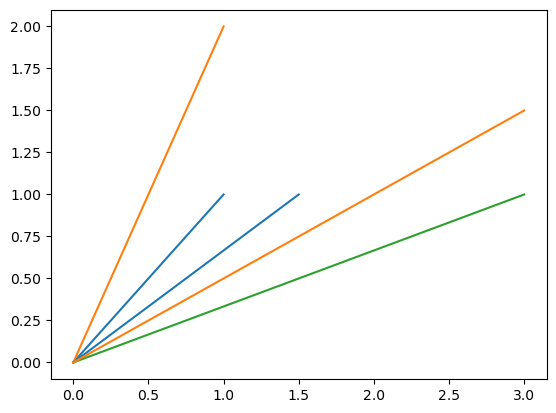

In [61]:
colors = cycle([f'C{i}' for i in range(3)])

plt.plot((0,1), (0,1), c=next(colors))
plt.plot((0,1), (0,2), c=next(colors))
plt.plot((0,3), (0,1), c=next(colors))
plt.plot((0,1.5), (0,1), c=next(colors))
plt.plot((0,3), (0,1.5), c=next(colors))
plt.show()

## DEMO `decode`

In [65]:
b'\xE6\x97\xA5\xE6\x9C\xAC'.decode('utf-8')

'日本'